Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.


In [1]:
import pandas as pd
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 


## 1 Исследуем данные

In [2]:
try:
    data = pd.read_csv('/Users/admin/Downloads/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')
    
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
89,90,15767954,Osborne,635,Germany,Female,28,3.0,81623.67,2,1,1,156791.36,0
7951,7952,15644699,Crawford,850,France,Female,40,0.0,0.00,2,1,0,1099.95,0
9706,9707,15754926,Lucchesi,512,France,Female,30,6.0,0.00,2,1,0,88827.31,0
4413,4414,15596575,Vale,615,Germany,Male,39,5.0,113193.51,2,1,1,52166.25,0
165,166,15585388,Sherman,660,Germany,Male,31,9.0,125189.75,2,1,1,139874.43,0
6351,6352,15794472,Brookes,553,France,Female,27,3.0,0.00,2,0,0,159800.16,0
3794,3795,15621409,Endrizzi,496,France,Male,32,4.0,127845.83,1,1,0,66469.20,0
8648,8649,15683053,Reyna,809,Spain,Female,48,2.0,0.00,1,1,0,160976.85,1
2984,2985,15694946,Hanson,663,France,Male,35,9.0,0.00,2,1,1,195580.28,0
6953,6954,15579109,Napolitano,574,Germany,Male,35,NaN,163856.76,1,1,1,15118.20,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Изучив данные, видим пропуски в столбце Tenure. 
Заполним пропуски в этом столбце медианой.

Также удалим три столбца, соответствующие идентификационным данным конкретного человека. Для обучения модели эти данные не имеют ценности.

In [5]:
data['Tenure']= data['Tenure'].fillna(data['Tenure'].median())
data = data.drop(['Surname','RowNumber','CustomerId'], axis=1)

In [6]:
#разделим на свойства и цель
target = data['Exited']
features = data.drop('Exited',axis=1)

In [7]:
#сперва отделим тренировочный набор
features_train, features_temporary, target_train, target_temporary = train_test_split(features, 
                                                                                      target,test_size=0.4, 
                                                                                      random_state=12345)
#далее разделяем оставшиеся данные на валидационный и тестовый наборы
features_valid, features_test, target_valid, target_test =train_test_split(features_temporary,
                                                                           target_temporary, 
                                                                           test_size=0.5, 
                                                                           random_state=12345)

Перед обучением проверим типы данных

In [8]:
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [9]:
#проверим, как разделились выборки
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 10) (6000,)
(2000, 10) (2000,)
(2000, 10) (2000,)


Подготовим данные. Будем кодировать категориальные переменные

In [10]:
features_train = pd.get_dummies(features_train,drop_first= True )
features_valid = pd.get_dummies(features_valid,drop_first= True )
features_test = pd.get_dummies(features_test,drop_first= True )

In [12]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

Так как в числе других моделей мы планируем исследовать логистическую регрессию, применим масштабирование признаков

## 2 Исследуем баланс классов


In [13]:
print(len(data.loc[data['Exited'] == 1]))
print(len(data.loc[data['Exited'] == 0]))

2037
7963


Видим, что соотношение классов приблизительно 4:1. 

Исследуем качество разных моделей - дерево решений, случайный лес, логистическая регрессия - без учета выявленного дисбаланса.

Также обучим DummyClassifier в качестве базовой модели.

## 3 Исследуем модели без учета дисбаланса классов

In [14]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=12345)
dummy_clf.fit(features_train, target_train)
predictions_dummy = dummy_clf.predict(features_valid)
probabilities_dummy = dummy_clf.predict_proba(features_valid)

print('f1:', f1_score(predictions_dummy, target_valid))
print('auc roc:',roc_auc_score(target_valid, probabilities_dummy[:, 1]))

f1: 0.1780487804878049
auc roc: 0.4833382732777237


In [15]:
# в цикле подберем глубину дерева.
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_auc_roc = 0

for depth in range(1,20):# для глубины от 1 до 10
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)#обучаем модель
    predictions_tree = model_tree.predict(features_valid)#получаем предсказание
    result_tree = f1_score(target_valid, predictions_tree) 
    probabilities_tree = model_tree.predict_proba(features_valid)
    #probabilities_one_valid_dummy = probabilities_dummy[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_tree[:, 1])
    #print(result_tree)
    
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
        best_depth_tree = depth
        best_auc_roc = auc_roc
        
    
   
    

In [16]:
# для лучшей модели выводим метрики и  подобранную глубину
print('Для решающего дерева:')
print('auc roc:', best_auc_roc)
print('f1:', best_result_tree)
print('Глубина', best_depth_tree)

Для решающего дерева:
auc roc: 0.8164631712023421
f1: 0.5696969696969697
Глубина 6


CPU times: user 3min 19s, sys: 2.53 s, total: 3min 22s
Wall time: 3min 23s


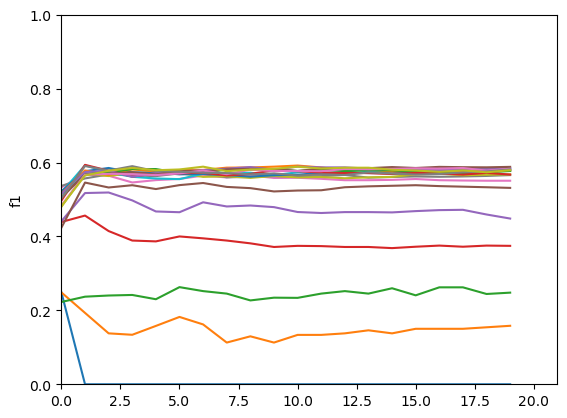

In [17]:
%%time
# Циклом подберем параметры для случайного леса - глубину и количество деревьев

best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est_forest = 0
best_roc_auc = 0

for depth in range (1,20):
    results_forest = []
    for est in range(1,201,10):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)#обучаем модель с заданным числом деревьев
        model_forest.fit(features_train,target_train)#обучаем модель
        predictions_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_forest)#model_forest.score(features_valid, target_valid)
        #probabilities_forest = model_forest.predict_proba(features_valid)
        #probabilities_one_valid_dummy = probabilities_dummy[:, 1]
        roc_auc = roc_auc_score(target_valid, model_forest.predict_proba(features_valid)[:,1])
        results_forest.append(result_forest)
    
        if result_forest > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result_forest
            best_depth_forest = depth
            best_est_forest = est
            best_roc_auc = roc_auc
            
    figsize = (3,4)       
    plt.plot(results_forest)
    plt.ylabel('f1')
    plt.xlim(0,21)
    plt.ylim(0,1)
    #plt.show()

        

In [18]:
print('Для случайного леса:')
print('F1:', best_result_forest)
print('Глубина:', best_depth_forest)
print('Количество деревьев:', best_est_forest)
print('roc auc:', best_roc_auc)

Для случайного леса:
F1: 0.5936599423631124
Глубина: 14
Количество деревьев: 11
roc auc: 0.8238330137491758


Построим график ROC кривой

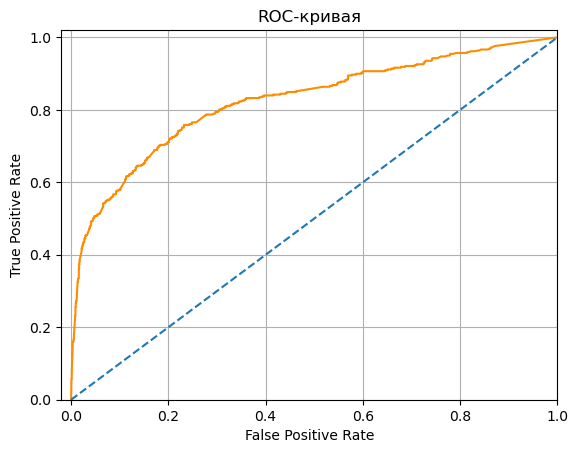

In [19]:
def roc_graph(target_valid, probabilities_one_valid):
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange") 
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая") 
    plt.grid()
    plt.show()
    
roc_graph(target_valid, best_model_forest.predict_proba(features_valid)[:,1])

In [20]:
model_reg = LogisticRegression(random_state=12345,solver='liblinear')
model_reg.fit(features_train, target_train)
predictions_reg = model_reg.predict(features_valid)

print('Для логистической регрессии:')
print('F1:', f1_score(target_valid,predictions_reg))
print('auc roc:', roc_auc_score(target_valid,model_reg.predict_proba(features_valid)[:,1]))

Для логистической регрессии:
F1: 0.33108108108108103
auc roc: 0.7587588238496482


Наилучший результат дает случайный лес. Логистическая регрессия дает очень низкий результат.


Попробуем улучшить результат, учитывая дисбаланс классов. 

Первый способ, который мы будем использовать - взвешивание классов. Для этого добавим в модели аргумент class_weight='balanced'

## 4 Улучшим качество моделей
Учитываем дисбаланс классов. Используем для этого три метода - взвешивание классов, downsampling, upsampling.

### 4.1 Взвешивание классов:

In [21]:
# взвешивание классов для дерева
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_auc_roc = 0
for depth in range(1,20):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth,class_weight = 'balanced')
    model_tree.fit(features_train, target_train)#обучаем модель
    predictions_tree = model_tree.predict(features_valid)#получаем предсказание
    result_tree = f1_score(target_valid, predictions_tree) #accuracy_score(target_valid, predictions_tree)#считаем accuracy (правильность)
    auc_roc =roc_auc_score(target_valid,predictions_tree)
    
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
        best_depth_tree = depth
        best_auc_roc = auc_roc

In [22]:
print('F1:',best_result_tree)
print('Глубина:', best_depth_tree)
print('roc auc:', best_auc_roc)

F1: 0.5963791267305644
Глубина: 5
roc auc: 0.7587588238496482


In [39]:
%%time
#взвешивание классов для леса

best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est_forest = 0
best_auc_roc = 0

for depth in range (1,20):
    for est in range(1,201,10):
        model_forest = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=est, class_weight = 'balanced')#обучаем модель с заданным числом деревьев
        model_forest.fit(features_train,target_train)#обучаем модель
        predictions_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_forest)#model_forest.score(features_valid, target_valid)
        auc_roc = roc_auc_score(target_valid,predictions_forest)
    
        if result_forest > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result_forest
            best_depth_forest = depth
            best_est_forest = est
            best_auc_roc = auc_roc

CPU times: user 3min 27s, sys: 2.92 s, total: 3min 30s
Wall time: 3min 31s


In [40]:
print('F1:', best_result_forest)
print('Глубина', best_depth_forest)
print('Количество деревьев:', best_est_forest)
print('auc roc:', best_auc_roc)

F1: 0.6293859649122807
Глубина 8
Количество деревьев: 181
auc roc: 0.7778779208681398


In [46]:
#взвешивание классов для регрессии
model_reg= LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_reg.fit(features_train, target_train)
predicted_valid = model_reg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))
print('auc roc:', roc_auc_score(target_valid,predicted_valid))

F1: 0.4888507718696398
auc roc: 0.6945753361682564


### 4.2 увеличение выборки (upsampling)

In [47]:
# напишем функцию для масштабирования выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)


<AxesSubplot:title={'center':'Class balance'}>

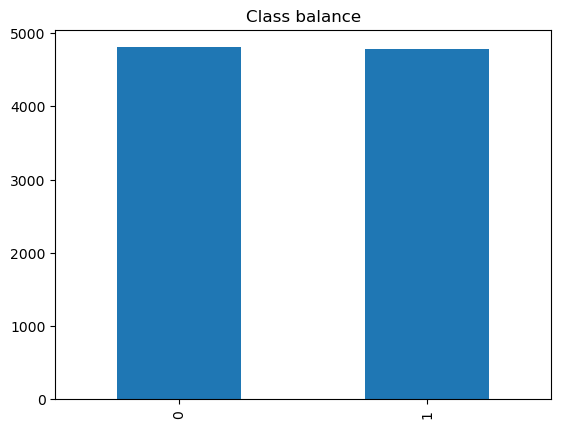

In [48]:
target_train_upsampled.value_counts().plot(kind='bar', title = 'Class balance')


In [49]:
# upsampling для дерева
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_auc_roc = 0

for depth in range(1,20):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train_upsampled, target_train_upsampled)#обучаем модель
    predictions_tree = model_tree.predict(features_valid)#получаем предсказание
    result_tree = f1_score(target_valid, predictions_tree) #accuracy_score(target_valid, predictions_tree)#считаем accuracy (правильность)
    auc_roc = roc_auc_score(target_valid,predictions_tree)
    
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
        best_depth_tree = depth
        best_auc_roc = auc_roc

In [50]:
print('Глубина:', best_depth_tree)
print('F1:', best_result_tree)
print('auc roc:', best_auc_roc)

Глубина: 5
F1: 0.5963791267305644
auc roc: 0.7587588238496482


In [51]:
%%time
# upsampling для случайного леса

best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est_forest = 0
best_auc_roc = 0

for depth in range (1,20):
    for est in range(1,201,10):
        model_forest = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=est)#обучаем модель с заданным числом деревьев
        model_forest.fit(features_train_upsampled,target_train_upsampled)#обучаем модель
        predictions_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_forest)#model_forest.score(features_valid, target_valid)
        roc_auc = roc_auc_score(target_valid,predictions_forest)
    
        if result_forest > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result_forest
            best_depth_forest = depth
            best_est_forest = est
            best_auc_roc = roc_auc

CPU times: user 4min 49s, sys: 4.42 s, total: 4min 53s
Wall time: 4min 56s


In [52]:
print('F1:', best_result_forest)
print('Глубина:', best_depth_forest)
print('Количество деревьев:', best_est_forest)
print('auc roc:', best_auc_roc)

F1: 0.6291179596174282
Глубина: 9
Количество деревьев: 71
auc roc: 0.7823223585915715


In [53]:
# upsampling для регрессии
model_reg= LogisticRegression(random_state=12345, solver='liblinear')
model_reg.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model_reg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))
print('auc_roc:', roc_auc_score(target_valid,predicted_valid))

F1: 0.4888507718696398
auc_roc: 0.6945753361682564


### 4.3 Уменьшение выборки (downsampling)

In [54]:
# напишем функцию для уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

<AxesSubplot:title={'center':'Class balance'}>

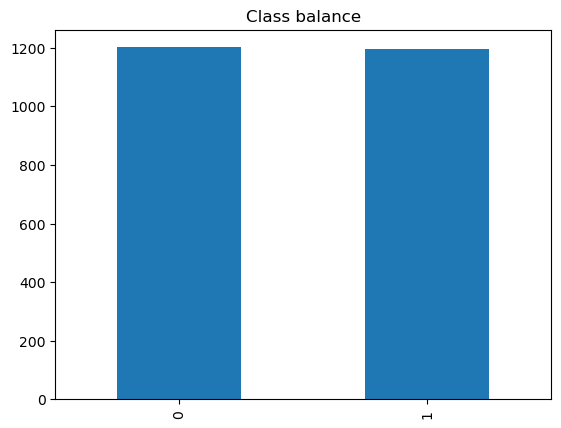

In [55]:
target_train_downsampled.value_counts().plot(kind='bar', title = 'Class balance')

In [56]:
# downsamling для решающего дерева
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_roc_auc = 0

for depth in range(1,20):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train_downsampled, target_train_downsampled)
    predictions_tree = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_tree) 
    roc_auc = roc_auc_score(target_valid,predictions_tree)
    
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
        best_depth_tree = depth
        best_roc_auc = roc_auc

In [57]:
print('Глубина:', best_depth_tree)
print('F1:', best_result_tree)
print('roc_auc:', best_roc_auc)

Глубина: 5
F1: 0.5943204868154158
roc_auc: 0.7635631718072333


In [58]:
%%time
# downsamling для случайного леса

best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est_forest = 0
best_auc_roc = 0

for depth in range (1,20):
    for est in range(1,201,10):
        model_forest = RandomForestClassifier(random_state=12345,max_depth=depth, n_estimators=est)
        model_forest.fit(features_train_downsampled,target_train_downsampled)
        predictions_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predictions_forest)
        roc_auc = roc_auc_score(target_valid,predictions_forest)
    
        if result_forest > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result_forest
            best_depth_forest = depth
            best_est_forest = est
            best_auc_roc = roc_auc

In [60]:
print(best_result_forest)
print(best_depth_forest)
print(best_est_forest)

0.6291179596174282
9
71


In [61]:
# downsamling для регрессии
model_reg= LogisticRegression(random_state=12345, solver='liblinear')
model_reg.fit(features_train_downsampled, target_train_downsampled)
predicted_valid = model_reg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))
print('auc roc:', roc_auc_score(target_valid,predicted_valid))

F1: 0.48406546080964685
auc roc: 0.6901067027988314


## 5 Проведем финальное тестирование
Проверим на тестовой выборке самую удачную модель. Это случайный лес с сбалансированными классами

In [62]:
best_model = RandomForestClassifier(
    random_state=12345, 
    max_depth = 9, 
    n_estimators=191, 
    class_weight = 'balanced')

best_model.fit(features_train,target_train)
predictions_best = best_model.predict(features_test)
result_best = f1_score(target_test, predictions_best)
auc_roc_best = roc_auc_score(target_test,predictions_best)       

In [63]:
print('F1:',result_best)
print('auc roc:', auc_roc_best)

F1: 0.6123853211009175
auc roc: 0.7578983346600286


## 6 Вывод
Получилен достаточно хороший результат, F1 = 0,61, auc roc = 0.75. Лучшая модель - случайный лес со сбалансированными классами. Поставленная задача выполнена